# Stock Market Predictions - LSTM Neural Networks

###### Ignacio Antequera Sanchez

# 0. Introduction
---

Hello Everyone! 

Welcome to my Stock Market Predictions Project using ```LSTM Neural Networks```. My name is Ignacio Antequera and in this notebook, I will be sharing with you how we can use a time-series model known as Long Short-Term Memory.

The logic behind this project is to use machine learning models that can look at the history of a sequence of data and correctly predict what the future elements of the sequence are going to be. This is where ```time series modeling``` comes in.

> Disclaimer: This project is solely for learning purposes and does not serve as a financial advisor. Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly.

This project can be dividede into two major sections:

- One-Step Ahead Prediction via Averaging: In this first half of the project, we will understand two important averaging techniques:
    - `Standard Averaging`
    - `Exponential Moving Average`
- Making Stock Movement Predictions Far into the Future Using LSTM

We will be using different daatsets and also different ways of accessing this data with the objective of easily switching our input data and hence test our models with different datasets.

### Import Libraries:

In [75]:
# Make sure that you have all these libaries available to run the code successfully

# Basic libraries
import numpy as np
import pandas as pd
from pandas_datareader import data
import os
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates
import urllib.request, json

# For visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 1. Downloading the data
---

There are two ways we can access data for this first half of the project:

- `Alpha Vnatage Stock API`: This API contains realtime and historical stock market data. This is a reliable source for historical market data that offers a wide range of financial datasets.

    - Since we going to make use of the American Airlines Stock market prices to make your predictions, we set the ticker to `"AAL"`. 
    - We define a `url_string`, which will return a JSON file with all the stock market data for American Airlines within the last 20 years.
    - We define a `file_to_save`, which will be the file to which we save the data. 
    - We will use the `ticker` variable that we defined beforehand to help name this file.
    - Next, we are going to specify a condition: if you haven't already saved data.
    - We will go ahead and grab the data from the URL that we set in `url_string`
    - We'll store the date, low, high, volume, close, open values to a pandas DataFrame df. 
    - We will save it to file_to_save. However, if the data is already there, we'll just load it from the CSV. (This is useful for future runs of the code)

- [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs): This is a huge stock market dataset that contains   Historical daily prices and volumes of all U.S. stocks and ETFs. For the purposes of this demo, I will be using this option. I will be working on HP's stock since it contains a good amount of data that will serve us good for our this demo. However, you may access other demos on this repository where I will be analyzing stocks whose data has been retrieved from Alphavantage. Note that if we select this option, you will need to copy the Stocks folder in the zip file to your project home folder.

In [76]:
data_source = 'kaggle' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '<your API key>'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)
else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


# 2. Data Exploration
---

Now that we have our data properly stored, let's take a quick look at its structure. But first, since we are going to be working on time series modelling, we need to make sure that the data is sorted by date.

In [77]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


# 3. Data Visualization
---

Now, let's take a look at what sort of data we have. We are interested in data with various patterns occurring over time.

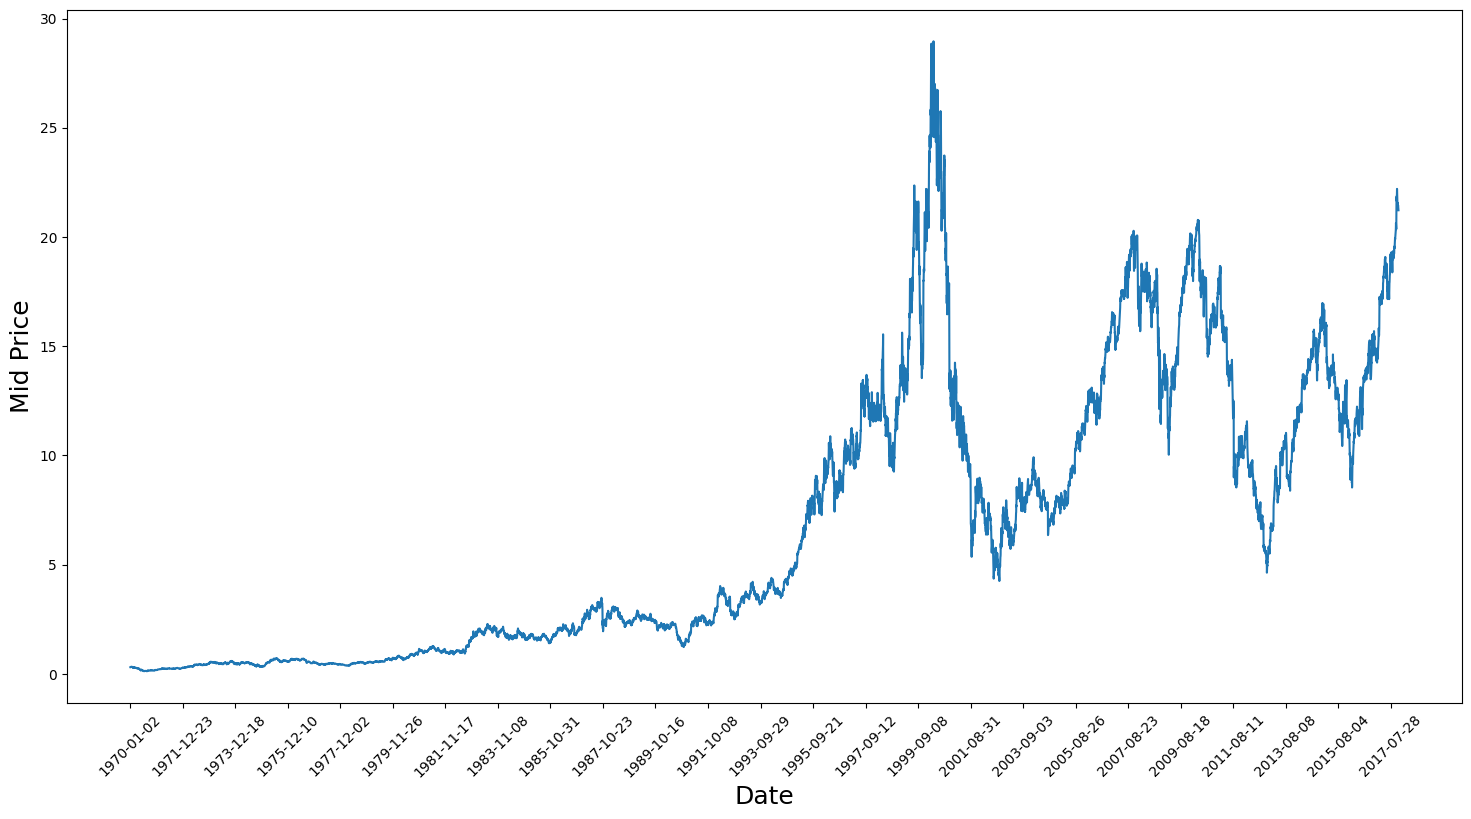

In [78]:
# Set the size of the figure
plt.figure(figsize = (18,9))

# Create the line plot
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)

# Set the x-axis tick marks to be every 500 rows in df
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)

# Set the x-axis and y-axis labels
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

# Display the plot
plt.show()

This graph provides valuable insights into various aspects. The reason we chose this particular company over others is due to the diverse range of behaviors exhibited by its stock prices over time, making it an excellent candidate for robust learning and providing ample opportunities to evaluate prediction accuracy across different scenarios.

It's worth noting that the stock prices around 2017 exhibit significantly higher values and greater fluctuations compared to those around the 1970s. Therefore, it's essential to ensure consistent value ranges for the data throughout the entire time frame. This normalization process will be addressed during the data normalization phase.

# 4. Splitting Data into Training set and Test set
---

We will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day.

In [79]:
# First calculate the mid prices from the highest and lowest
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices+low_prices)/2.0

This will allow us to split the training data and test data.

In [80]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

# Verify the shapes of the training and testing sets
print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)

Training set shape: (11000,)
Testing set shape: (1075,)


It appears that our data has been properly split into training and testing sets. The training set contains 11,000 data points, while the testing set contains 1,075 data points. This aligns with our expectations, as the first 11,000 data points were assigned to the training set, and the remaining data points were assigned to the testing set.

# 5. Normalizing the Data
---

Before proceeding with training our model, it's important to normalize the data to ensure that all features are on a similar scale. Normalization helps in improving the convergence speed and performance of machine learning algorithms, especially those sensitive to feature scales.

Once the data is normalized, we can proceed with training your model using the training set and evaluating its performance on the normalized testing set.

When scaling, we normalize both test and train data with respect to training data because we are not supposed to have access to test data.

In [81]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

This scaler ensures that the data is scaled to be between 0 and 1

Due to the observation we made earlier, that is, different time periods of data have different value ranges, we will normalize the data by splitting the full series into windows. If we don't do this, the earlier data will be close to 0 and will not add much value to the learning process. In this case we are going to split the data into 4 windows of same size.

In [82]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0, 10000, smoothing_window_size):
    # Fit the scaler to the current window of training data and smooth data
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    
    # Transform and normalize the current window of training data and smooth data
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape the data back to the shape of [data_size]

In [83]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

We can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

In [84]:
# Initialize variables for exponential moving average (EMA) and smoothing factor (gamma)
EMA = 0.0
gamma = 0.1

# Perform exponential moving average smoothing on the training data
for ti in range(11000):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Concatenate the smoothed training data with the normalized test data for visualization and testing purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

# 6. One-Step Ahead Prediction via Averaging
---
We can better understand the difficulty of this problem by first trying to model this as an average calculation problem. Averaging mechanisms allow us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. 

However, we are going to look at two averaging techniques below:
- `Standard Averaging`
- `Exponential Moving Average`

We will evaluate  the results produced by the two algorithms both qualitatively (visual inspection) and quantitatively (Mean Squared Error).

### Standard Averaging

In this method, you will try to predict the future stock market prices as an average of the previously observed stock market prices within a fixed size window (say previous 100 days). In other words, you say the prediction at `t+1` is the average value of all the stock prices you observed within a window of `t` to `t-N`.

In [85]:
# Define the window size for standard averaging
window_size = 100

# Initialize lists to store predictions, MSE errors, and prediction dates
std_avg_predictions = []
mse_errors = []
std_avg_dates = []

# Calculate the total number of data points in the training set
N = len(train_data)

# Iterate over the indices of the training data, starting from window_size
for pred_idx in range(window_size, N):
    # Calculate the prediction date
    date = df['Date'].iloc[pred_idx]

    # Calculate the standard average prediction
    prediction = np.mean(train_data[pred_idx - window_size:pred_idx])
    std_avg_predictions.append(prediction)

    # Calculate the squared error and append it to the list of MSE errors
    mse_errors.append((prediction - train_data[pred_idx]) ** 2)
    std_avg_dates.append(date)

# Print the MSE error for standard averaging
print('MSE error for standard averaging: %.5f' % (0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


It seems like the Mean Squared Error (MSE) for standard averaging in our output is 0.00005. This indicates that the standard averaging method resulted in a relatively low MSE error, which suggests that the predictions are close to the actual values on average.

A low MSE error indicates that the model's predictions are accurate and closely match the actual values. In the context of stock market prediction, a low MSE error indicates that the standard averaging method is performing well in predicting future stock prices based on historical data.

---

Let's Take a look at the averaged results below.

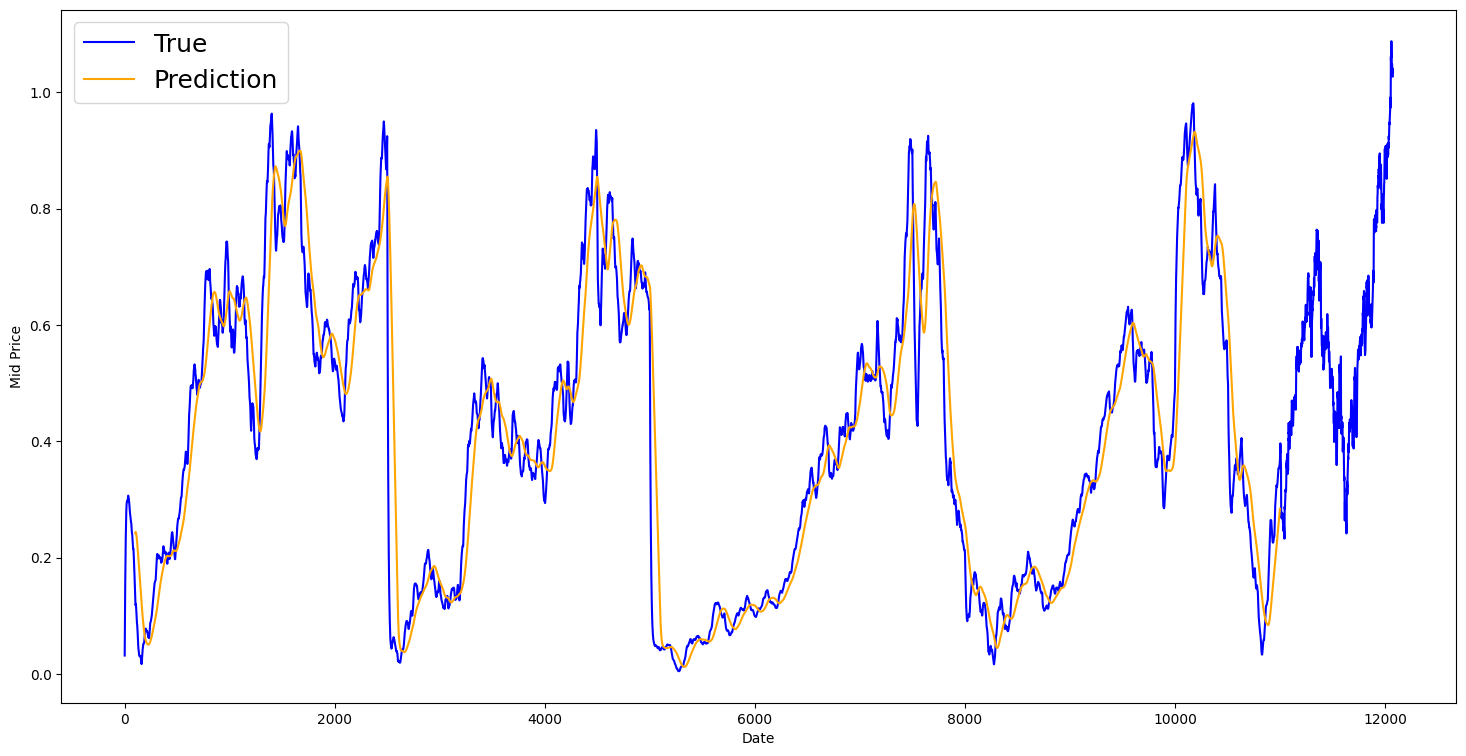

In [86]:
# Visualize the true mid prices and standard averaging predictions
plt.figure(figsize=(18, 9))

# Plot the true mid prices
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='True')

# Plot the standard averaging predictions
plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='Prediction')

# Set x-axis label
plt.xlabel('Date')

# Set y-axis label
plt.ylabel('Mid Price')

# Add legend to the plot
plt.legend(fontsize=18)

# Display the plot
plt.show()

The model appears to perform reasonably well for very short-term predictions (one day ahead). This is sensible since stock prices typically do not undergo drastic changes overnight.

### Exponential Moving Average

In the exponential moving average method, we make our predictions such that:

x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t

where \( EMA_0 = 0 \) and \( EMA \) is the exponential moving average value maintained over time.

The above equation basically calculates the exponential moving average from $t+1$ time step and uses that as the one step ahead prediction. $\gamma$ decides what the contribution of the most recent prediction is to the EMA. For example, a $\gamma=0.1$ gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. See how good this looks when used to predict one-step ahead below.

In [87]:
# Set the window size for the exponential moving average
window_size = 100

# Calculate the total number of data points in the training set
N = len(train_data)

# Initialize lists to store predictions, dates, and MSE errors
run_avg_predictions = []
run_avg_x = []
mse_errors = []

# Initialize the running mean using the first window of data
running_mean = np.mean(train_data[:window_size])
run_avg_predictions.append(running_mean)

# Define the decay factor for exponential decay
decay = 0.5

# Iterate over the indices of the training data
for pred_idx in range(1, N):
    # Calculate the running mean using exponential decay
    running_mean = running_mean * decay + (1.0 - decay) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    
    # Calculate the squared error and append it to the list of MSE errors
    squared_error = (running_mean - train_data[pred_idx]) ** 2
    mse_errors.append(squared_error)
    
    # Append date if available
    run_avg_x.append(date)  # Make sure 'date' is defined within the loop

# Calculate the MSE error for EMA averaging
mse_error_ema = 0.5 * np.mean(mse_errors)
print('MSE error for EMA averaging: %.5f' % mse_error_ema)

MSE error for EMA averaging: 0.00003


This low MSE value suggests that the EMA method is performing well in predicting future stock prices one step ahead, based on the given historical data. A lower MSE indicates that the predictions are close to the actual values, demonstrating the effectiveness of the EMA averaging technique in this context.

Now, let's visualize the results of the EMA predictions along with the true values.

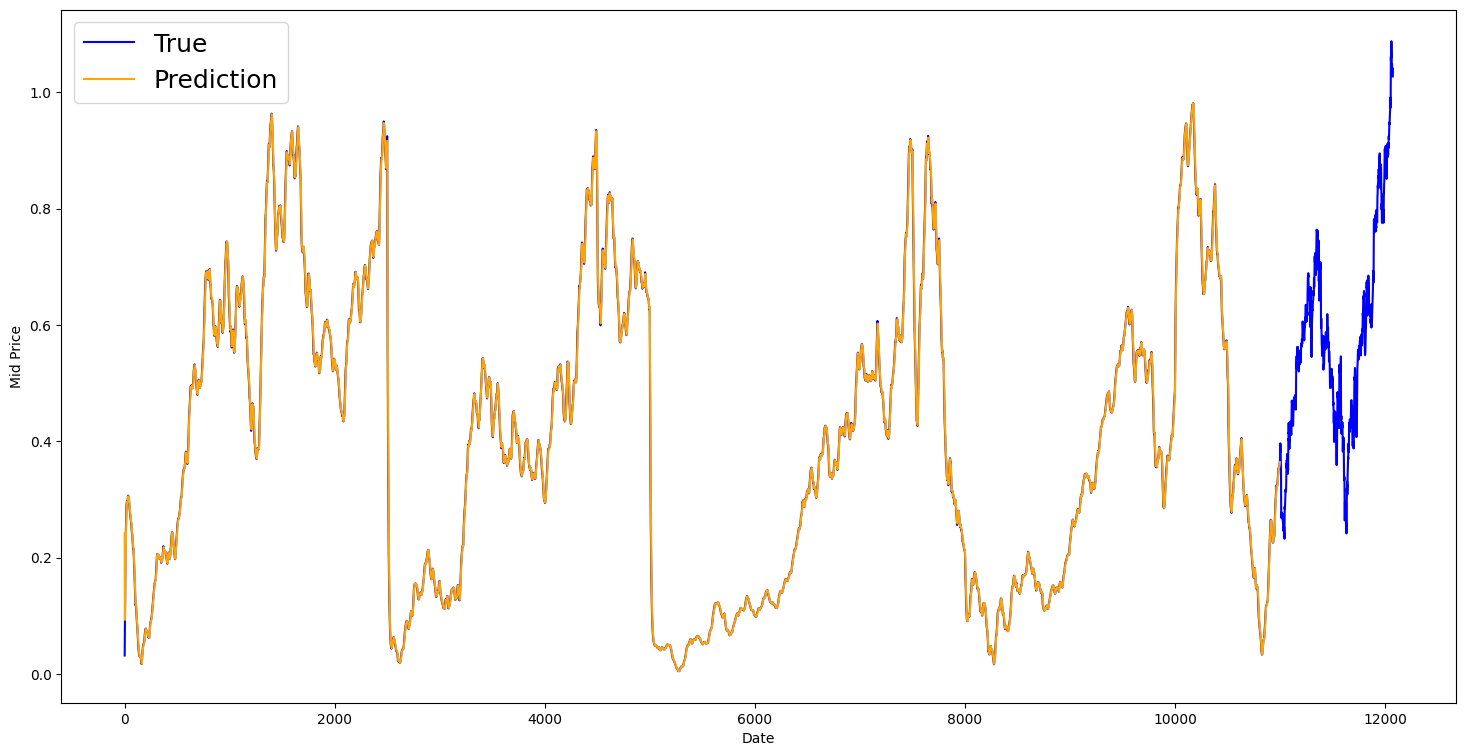

In [88]:
# Visualize the true values and predictions using Exponential Moving Average (EMA)
plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='True')  # Plot true values
plt.plot(range(0, N), run_avg_predictions, color='orange', label='Prediction')  # Plot EMA predictions

plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Mid Price')  # Set y-axis label
plt.legend(fontsize=18)  # Add legend with font size
plt.show()  # Display the plot

Exponential Moving Average (EMA) may seem to perform well in predicting the next day's stock market value, as evidenced by its low Mean Squared Error (MSE) and close alignment with the true distribution. However, in practical terms, knowing just the next day's value isn't particularly useful. What's more valuable is understanding whether stock prices will rise or fall over the next 30 days. Attempting to predict larger windows of time reveals the limitations of EMA.

For instance, consider the scenario where $x_t=0.4$, $EMA=0.5$, and $\gamma = 0.5$:
- Using the equation $X_{t+1} = EMA_t = \gamma \times EMA_{t-1} + (1 - \gamma)X_t$, we find $x_{t+1} = 0.5 \times 0.5 + (1-0.5) \times 0.4 = 0.45$. Consequently, $X_{t+1} = EMA_t = 0.45$.

Applying the same logic for $X_{t+2}$: 
- we get $X_{t+2} = \gamma \times EMA_t + (1-\gamma)X_{t+1}$.
- Substituting the values, $X_{t+2} = \gamma \times EMA_t + (1-\gamma) EMA_t = EMA_t = 0.45$. 

This means that regardless of how many steps into the future we predict, we'll always get the same answer.

To address this limitation and obtain more meaningful predictions, we can explore momentum-based algorithms. These algorithms assess whether recent values have been increasing or decreasing, rather than focusing on exact values. For example, if prices have been declining in recent days, these algorithms might predict a lower price for the next day, which aligns with intuitive expectations. However, for a more sophisticated approach, we'll utilize a Long Short-Term Memory (LSTM) model.

LSTM models have gained popularity in time series prediction due to their ability to effectively model temporal data. We'll investigate whether there are discernible patterns in the data that can be leveraged for more accurate predictions.

# 7. Making Stock Movement Predictions Far into the Future Using LSTM
---
Long Short-Term Memory models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future. In this second part of the project, we'll explore a different dataset from which we will randomly select a stock and predict its future price using LSTM models. The dataset contains all daily CAC40 Stocks from 2010 to date. Here is the link to access the dataset: [CAC40 Stocks Dataset](https://www.kaggle.com/datasets/bryanb/cac40-stocks-dataset?select=preprocessed_CAC40.csv)

Let's take a look at the dataset that we are going to be using:

In [89]:
# Reading our dataset
df_2 = pd.read_csv('Stocks/preprocessed_CAC40.csv', parse_dates=['Date'])
df_2.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


## Exploratory Data Analysis
---

### Preprocessing

In [90]:
# Dropping unnecessary column
df_2.drop(['Unnamed: 0'], axis=1, inplace=True)

In [91]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df_2[df_2['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [92]:
# Selecting any random company out of our 'Name' column
company_name = random.choice(df_2['Name'].unique().tolist())

# Setting the start and end date
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2020,1,1)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)

Let's look at the resulting dataset after randomly selecting a stock and applying these initial modifications:

In [93]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
23461,Crédit Agricole,2019-12-30,15.21,15.17,15.21,15.17,400
23462,Crédit Agricole,2019-12-27,15.07,15.07,15.07,15.07,NaN
23463,Crédit Agricole,2019-12-23,15.11,15.11,15.11,15.11,NaN
23464,Crédit Agricole,2019-12-20,15.05,15.03,15.08,15.03,51
23465,Crédit Agricole,2019-12-19,14.93,15.02,15.02,14.93,"1,71"


### Visualization

Let's build some charts that will help us visualize our data.

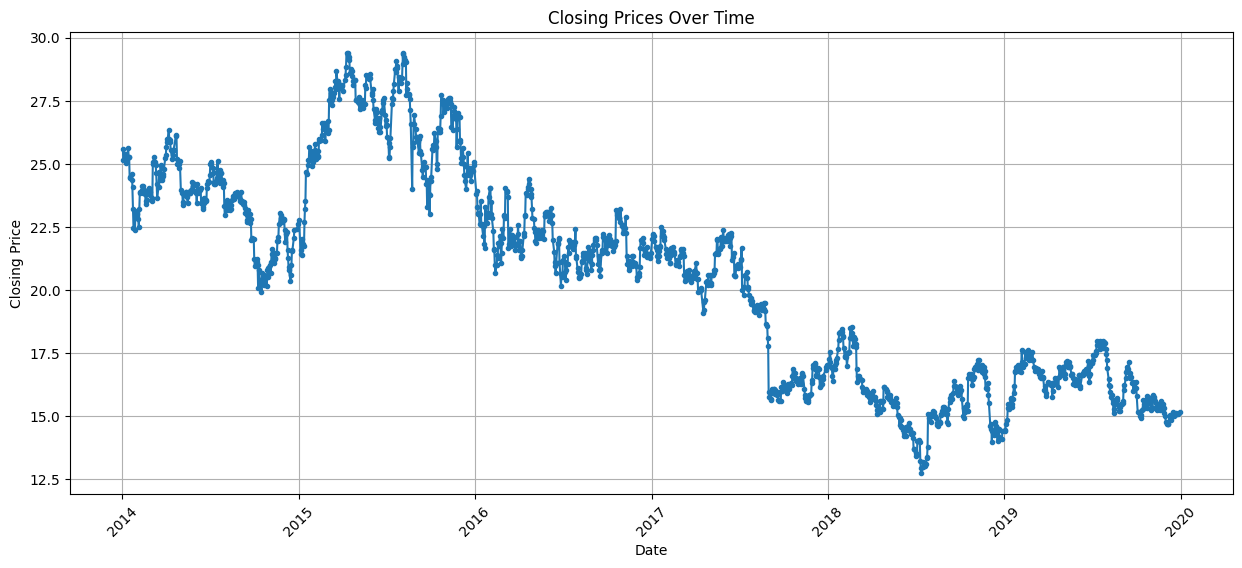

In [94]:
# Line Chart of Closing Prices Over Time

# Convert 'Date' column to datetime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

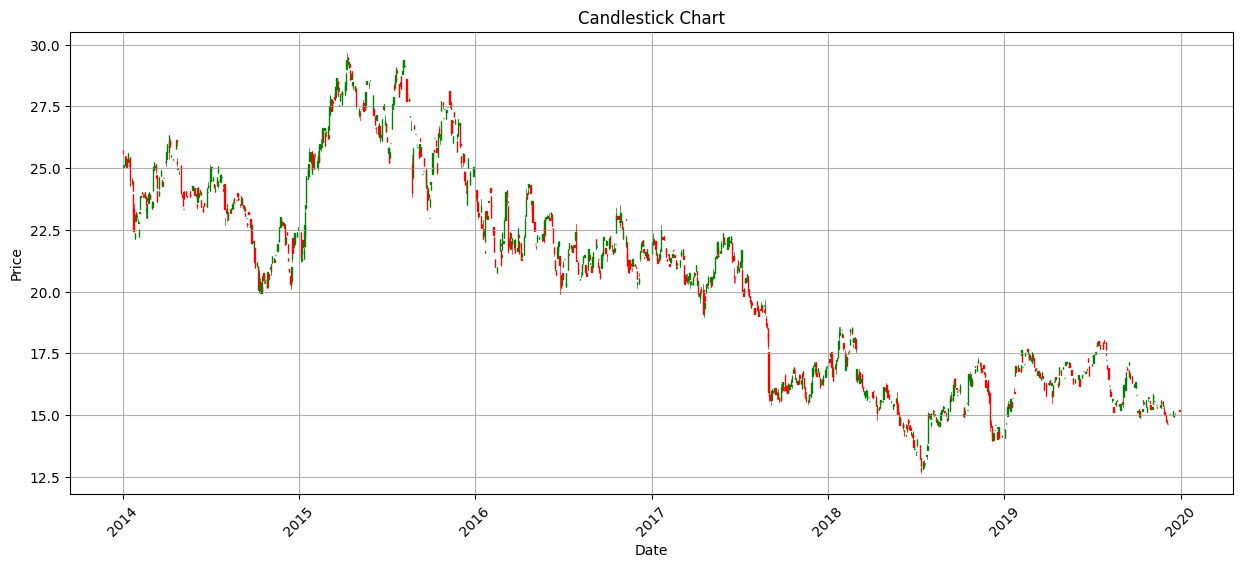

In [95]:
# Candlestick Chart

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

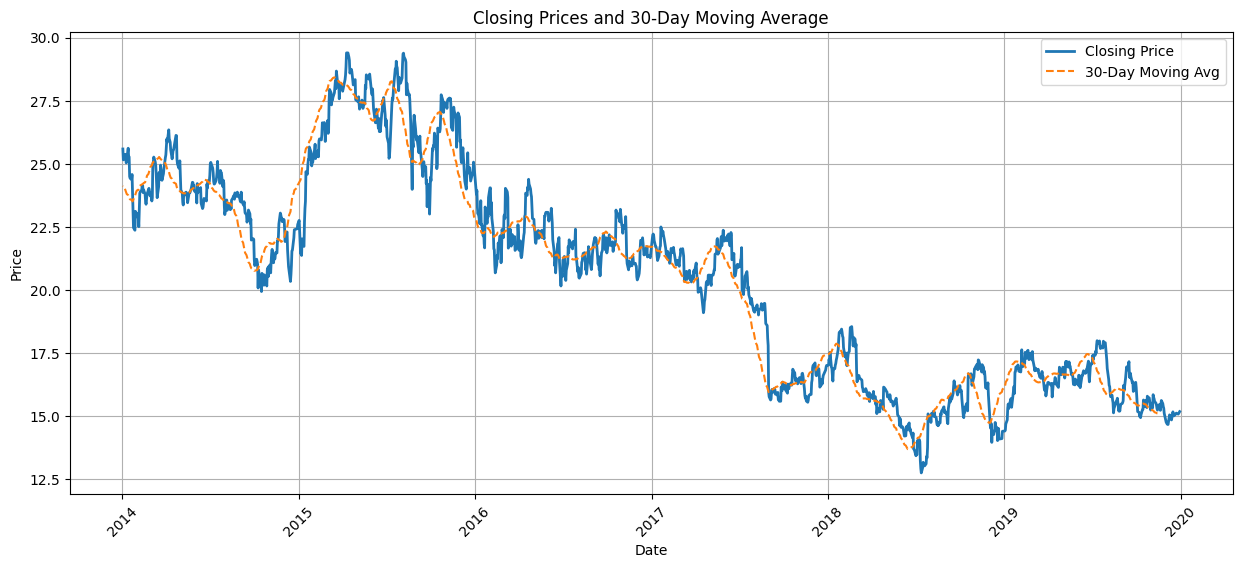

In [96]:
# Closing Prices and Moving Average plot

window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

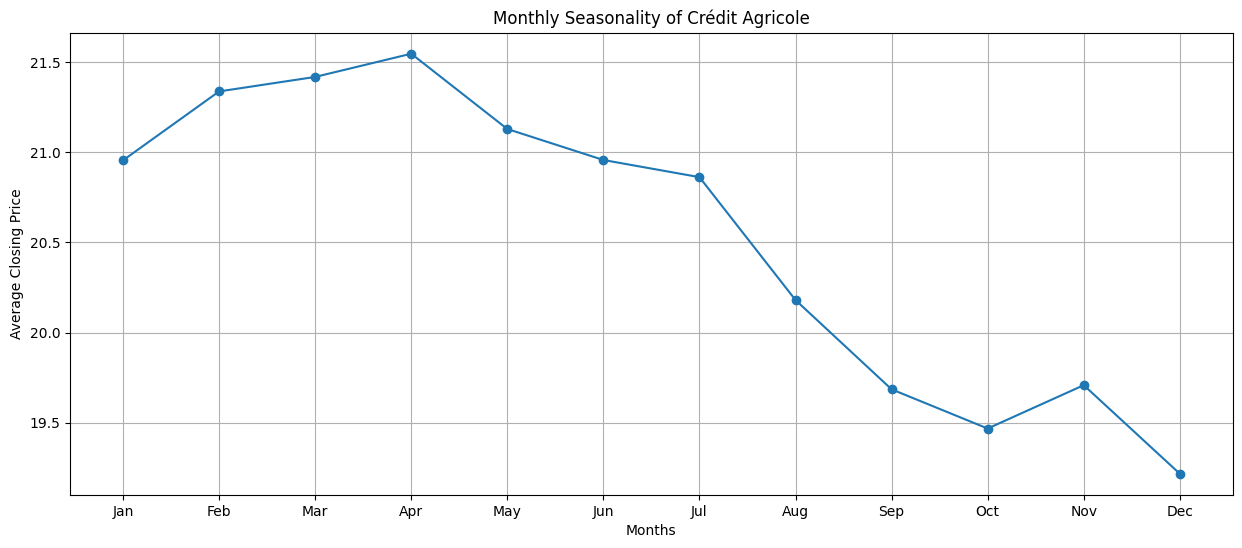

In [97]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [98]:
# Let's take a look at the structure of this new Month sub-dataset
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Month
23461,Crédit Agricole,2019-12-30,15.21,15.17,15.21,15.17,400,12
23462,Crédit Agricole,2019-12-27,15.07,15.07,15.07,15.07,NaN,12
23463,Crédit Agricole,2019-12-23,15.11,15.11,15.11,15.11,NaN,12
23464,Crédit Agricole,2019-12-20,15.05,15.03,15.08,15.03,51,12
23465,Crédit Agricole,2019-12-19,14.93,15.02,15.02,14.93,"1,71",12


### Normalization

In [99]:
# Create a new DataFrame that contains only the 'Closing_Price' column from the original specific_df
new_df = specific_df.reset_index()['Closing_Price']

In [100]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

### Splitting Data into Training and Testing sets

In [101]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [102]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)


# Checking the structure of our training and testing sets
print("Training set size: ")
print(X_train.shape), print(y_train.shape)
print("Testing set size: ")
print(X_test.shape), print(y_test.shape)

Training set size: 
(1151, 60)
(1151,)
Testing set size: 
(243, 60)
(243,)


(None, None)

In [103]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Model Training
---

In [104]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

# Check the structure of our model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Compile our model
model.compile(loss='mean_squared_error',optimizer='adam')

In [106]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath='Stocks/my_weights.keras', save_best_only=True)

# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints, early_stopping])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0583 - val_loss: 0.0044
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

In [107]:
# Make prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [108]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [109]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

19.914207708109288
22.89680886056127


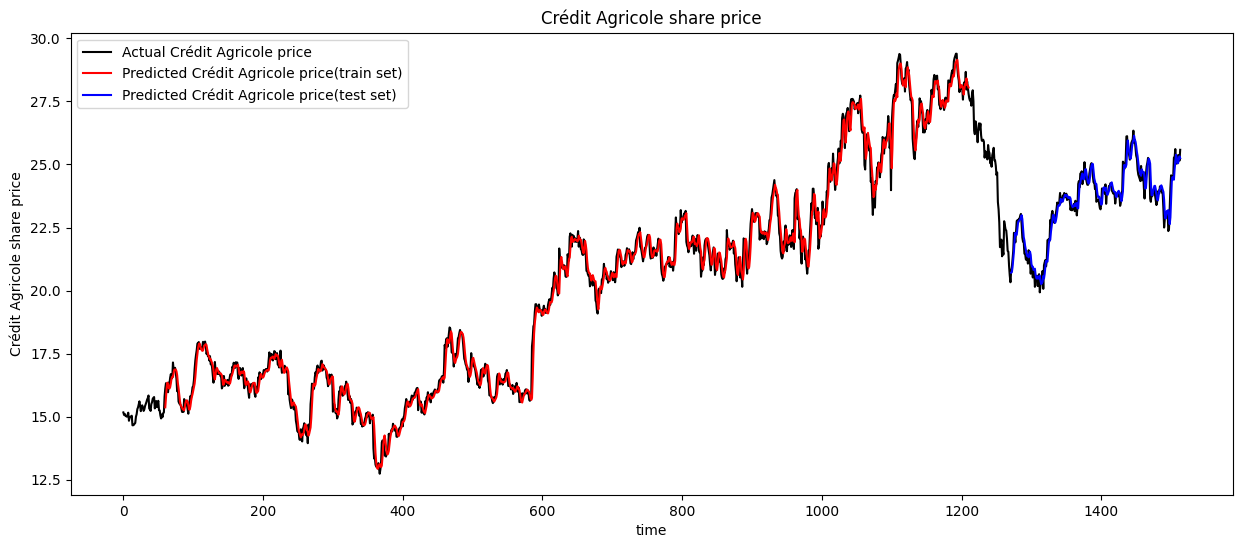

In [110]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()

In [111]:
# To predict for the next 10 days, we'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("\n")
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predictions for the next 10 days:
Day 1: Predicted Price = 25.247207641601562
Day 2: Predicted Price = 25.218698501586914
Day 3: Predicted Price = 25.215112686157227
Day 4: Predicted Price = 25.220195770263672
Day 5: Predicted Price = 25.228492736816406
Day 6: Predicted Price = 25.238309860229492
Day 7: Predicted Price = 25.248855590820312
Day 8: Predicted Price = 25.259737014770508
Day 9: Predicted Price = 25.270864486694336
Day 10: Predicted Price = 25.28235626220703


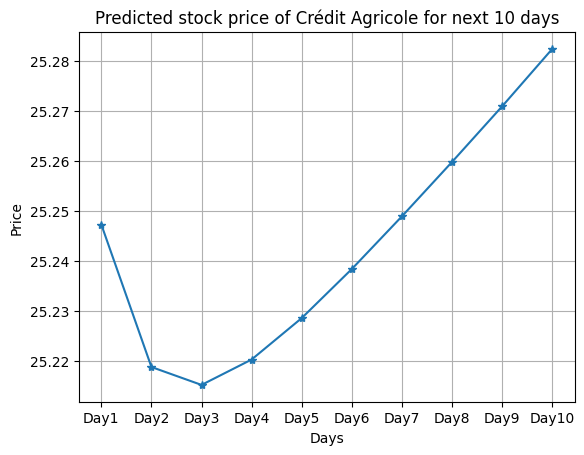

In [112]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()

# 8. Reflection and Conclusion
---

This project explored the potential of various methods for stock price prediction, including averaging techniques and LSTM neural networks. While the project primarily serves as an educational exercise highlighting the capabilities of different approaches, it also provides insights into the challenges and limitations of stock market prediction.

**Models and Techniques:**

* **Averaging Techniques**: Both standard averaging and exponential moving average (EMA) were employed for one-step ahead predictions. These methods are simple to implement and interpret, but their accuracy is limited, particularly for capturing complex market trends and unforeseen events.
* **LSTM Neural Networks**: This project showcased the application of a deep learning model, specifically an LSTM network, for longer-term stock movement predictions. LSTMs excel at capturing temporal dependencies within time series data. However, their performance heavily relies on the quality and quantity of available data, the choice of hyperparameters, and the overall model architecture.

**Tools and Technologies:**

* **Python**: The project utilized Python as the primary programming language, leveraging various libraries for data manipulation, visualization, model building, and evaluation. Key libraries included:
    * **NumPy**: Numerical computations and data manipulation
    * **Pandas**: Data analysis and manipulation
    * **Matplotlib**: Data visualization
    * **Scikit-learn**: Machine learning algorithms and tools (e.g., MinMaxScaler)
    * **Keras (with TensorFlow backend):** Deep learning framework for building and training the LSTM model
* **Data Sources**: The project utilized two data sources:
    * **Kaggle**: Publicly available historical stock price data for educational purposes.
    * **Alpha Vantage API**: Alternative data source requiring an API key (not used in this specific project due to educational focus).

**Evaluation and Results:**

* **Averaging Techniques**: Both averaging methods provided basic predictions, with EMA generally performing slightly better due to its weighting mechanism. However, their limitations were evident in their inability to capture significant market movements and potential trend reversals.
* **LSTM Neural Network**: The LSTM model showcased the ability to learn complex patterns within the data and generate predictions beyond one-step ahead. Nevertheless, the model exhibited limitations common to machine learning approaches:
    * **Sensitivity to data quality and quantity**: Larger and more comprehensive datasets can potentially improve performance.
    * **Hyperparameter tuning**: Tuning of various model parameters (e.g., number of layers, neurons, learning rate) can significantly impact prediction accuracy.
    * **Overfitting**: The model could potentially overfit the training data, leading to poor performance on unseen data.

**Overall, the project successfully explored various approaches to stock price prediction, highlighting the potential and limitations of each method. It serves as a reminder that the stock market is inherently complex and influenced by numerous interconnected factors, making accurate prediction a challenging task.**

**References:**

- [Datacamp](https://www.datacamp.com/tutorial/lstm-python-stock-market)
- [Predict-Stocks using LSTM - Kaggle](https://www.kaggle.com/code/dbdmobile/predict-stocks-using-lstm)

Kindly find my contact details listed below for your convenience. Your input is greatly appreciated.

Ignacio Antequera Sanchez

***

[LinkedIn](https://www.linkedin.com/in/ignacio-antequera)  ||  [GitHub](https://github.com/Ignacio-Antequera)  ||  [Leetcode](https://leetcode.com/Ignacio_antequera)

